# Using STGCN for speed prediction of the traffic

The details about the data is shown in the notebook
https://github.com/mhmdrdwn/traffic/blob/main/notebooks/tgcn-seoul-dataset.ipynb

The data: https://github.com/yuyolshin/SeoulSpeedData

In [1]:
from IPython.display import clear_output

In [2]:
"""Implementation of the STGCN is taken from the following github repository """
!git clone https://github.com/Aguin/STGCN-PyTorch.git

Cloning into 'STGCN-PyTorch'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 29 (delta 7), reused 26 (delta 7), pack-reused 0
Unpacking objects: 100% (29/29), 8.18 MiB | 3.11 MiB/s, done.


In [3]:
import torch
import numpy as np
import pandas as pd

def read_data(features_csv, adj_csv):
    urban_core_speeds = pd.read_csv(features_csv, header=None)
    adj_matrix_df = pd.read_csv(adj_csv, header=None)
    adj_matrix = np.array(adj_matrix_df)

    speeds_df = urban_core_speeds.iloc[:, 7:]
    speeds = np.array(speeds_df)
    
    return adj_matrix_df, urban_core_speeds, adj_matrix, speeds

Spatiotemporal Graph Convolutional Network (STGCN) is explained in the article https://arxiv.org/abs/1709.04875




In [4]:
"""Ref: https://github.com/Aguin/STGCN-PyTorch.git"""

import math
import random
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class align(nn.Module):
    def __init__(self, c_in, c_out):
        super(align, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        if c_in > c_out:
            self.conv1x1 = nn.Conv2d(c_in, c_out, 1)

    def forward(self, x):
        if self.c_in > self.c_out:
            return self.conv1x1(x)
        if self.c_in < self.c_out:
            return F.pad(x, [0, 0, 0, 0, 0, self.c_out - self.c_in, 0, 0])
        return x

class temporal_conv_layer(nn.Module):
    def __init__(self, kt, c_in, c_out, act="relu"):
        super(temporal_conv_layer, self).__init__()
        self.kt = kt
        self.act = act
        self.c_out = c_out
        self.align = align(c_in, c_out)
        if self.act == "GLU":
            self.conv = nn.Conv2d(c_in, c_out * 2, (kt, 1), 1)
        else:
            self.conv = nn.Conv2d(c_in, c_out, (kt, 1), 1)

    def forward(self, x):
        x_in = self.align(x)[:, :, self.kt - 1:, :]
        if self.act == "GLU":
            x_conv = self.conv(x)
            return (x_conv[:, :self.c_out, :, :] + x_in) * torch.sigmoid(x_conv[:, self.c_out:, :, :])
        if self.act == "sigmoid":
            return torch.sigmoid(self.conv(x) + x_in)
        return torch.relu(self.conv(x) + x_in)

class spatio_conv_layer(nn.Module):
    def __init__(self, ks, c, Lk):
        super(spatio_conv_layer, self).__init__()
        self.Lk = Lk
        self.theta = nn.Parameter(torch.FloatTensor(c, c, ks))
        self.b = nn.Parameter(torch.FloatTensor(1, c, 1, 1))
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.theta, a=math.sqrt(5))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.theta)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.b, -bound, bound)

    def forward(self, x):
        x_c = torch.einsum("knm,bitm->bitkn", self.Lk, x)
        x_gc = torch.einsum("iok,bitkn->botn", self.theta, x_c) + self.b
        return torch.relu(x_gc + x)

class st_conv_block(nn.Module):
    def __init__(self, ks, kt, n, c, p, Lk):
        super(st_conv_block, self).__init__()
        self.tconv1 = temporal_conv_layer(kt, c[0], c[1], "GLU")
        self.sconv = spatio_conv_layer(ks, c[1], Lk)
        self.tconv2 = temporal_conv_layer(kt, c[1], c[2])
        self.ln = nn.LayerNorm([n, c[2]])
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_s = self.sconv(x_t1)
        x_t2 = self.tconv2(x_s)
        x_ln = self.ln(x_t2.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)        
        return self.dropout(x_ln)

class fully_conv_layer(nn.Module):
    def __init__(self, c):
        super(fully_conv_layer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class output_layer(nn.Module):
    def __init__(self, c, T, n):
        super(output_layer, self).__init__()
        self.tconv1 = temporal_conv_layer(T, c, c, "GLU")
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = temporal_conv_layer(1, c, c, "sigmoid")
        self.fc = fully_conv_layer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)

class STGCN(nn.Module):
    def __init__(self, ks, kt, bs, T, n, Lk, p):
        super(STGCN, self).__init__()
        self.st_conv1 = st_conv_block(ks, kt, n, bs[0], p, Lk)
        self.st_conv2 = st_conv_block(ks, kt, n, bs[1], p, Lk)
        self.output = output_layer(bs[1][2], T - 4 * (kt - 1), n)

    def forward(self, x):
        x_st1 = self.st_conv1(x)
        x_st2 = self.st_conv2(x_st1)
        return self.output(x_st2)
    

def scaled_laplacian(A):
    n = A.shape[0]
    d = np.sum(A, axis=1)
    L = np.diag(d) - A
    for i in range(n):
        for j in range(n):
            if d[i] > 0 and d[j] > 0:
                L[i, j] /= np.sqrt(d[i] * d[j])
    lam = np.linalg.eigvals(L).max().real
    return 2 * L / lam - np.eye(n)

def cheb_poly(L, Ks):
    n = L.shape[0]
    LL = [np.eye(n), L[:]]
    for i in range(2, Ks):
        LL.append(np.matmul(2 * L, LL[-1]) - LL[-2])
    return np.asarray(LL)

## Using Seoul Urban Core Data

In [5]:
adj_matrix_df, urban_core_speeds, adj_matrix, speeds = read_data(
    '../input/seoul-speed-data/urban-core.csv', 
    '../input/seoul-speed-data/Adj(urban-core).csv')

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Ks, Kt = 3, 3
L = scaled_laplacian(adj_matrix)
Lk = cheb_poly(L, Ks)
Lk = torch.Tensor(Lk.astype(np.float32)).to(device)

Lk.shape

torch.Size([3, 304, 304])

In [7]:
"""Train test split the data"""
train_test_split = 0.75

split = int(speeds.shape[1] * train_test_split)
train_data = speeds[:, :split-int(0.1*split)]
test_data = speeds[:, split:]
val_data = speeds[:, split-int(0.1*split):split]

print("Train data: ", train_data.shape)
print("Test data: ", test_data.shape)
print("Val data: ", val_data.shape)

Train data:  (304, 5832)
Test data:  (304, 2160)
Val data:  (304, 648)


In [8]:
"""Min max standardizing the data"""
max_speed = train_data.max()
min_speed = train_data.min()

train_data = (train_data - min_speed) / (max_speed - min_speed)
test_data = (test_data - min_speed) / (max_speed - min_speed)
val_data = (val_data - min_speed) / (max_speed - min_speed)


train_data.shape, test_data.shape, val_data.shape

((304, 5832), (304, 2160), (304, 648))

In [9]:
"""Ref: https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html"""

sequence_len = 10
prediction_len = 1

def build_features_labels(sequence_len, prediction_len, train_data, test_data, val_data):
    X_train, Y_train, X_test, Y_test, X_val, Y_val = [], [], [], [], [], []

    for i in range(train_data.shape[1] - int(sequence_len + prediction_len - 1)):
        a = train_data[:, i : i + sequence_len + prediction_len]
        X_train.append(a[:, :sequence_len])
        Y_train.append(a[:, sequence_len:sequence_len+prediction_len])

    for i in range(test_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = test_data[:, i : i + sequence_len + prediction_len]
        X_test.append(b[:, :sequence_len])
        Y_test.append(b[:, sequence_len:sequence_len+prediction_len])
        
    for i in range(val_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = val_data[:, i : i + sequence_len + prediction_len]
        X_val.append(b[:, :sequence_len])
        Y_val.append(b[:, sequence_len:sequence_len+prediction_len])
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    X_val = np.array(X_val)
    Y_val = np.array(Y_val)
    
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

X_train, Y_train, X_test, Y_test, X_val, Y_val = build_features_labels(sequence_len, 
                                                                       prediction_len, 
                                                                       train_data, 
                                                                       test_data, 
                                                                       val_data)

X_train_shape = X_train.shape
X_test_shape = X_test.shape
X_val_shape = X_val.shape

X_train = X_train.reshape(X_train_shape[0], 1, X_train_shape[2],  X_train_shape[1])
X_test = X_test.reshape(X_test_shape[0], 1, X_test_shape[2], X_test_shape[1])
X_val = X_val.reshape(X_val_shape[0], 1, X_val_shape[2], X_val_shape[1])
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1])
Y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
Y_val = Y_val.reshape(Y_val.shape[0], Y_val.shape[1])

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(X_val.shape)
print(Y_val.shape)

(5822, 1, 10, 304)
(5822, 304)
(2150, 1, 10, 304)
(2150, 304)
(638, 1, 10, 304)
(638, 304)


In [10]:
X_test = torch.Tensor(X_test).to(device)
X_train = torch.Tensor(X_train).to(device)
X_val = torch.Tensor(X_val).to(device)
Y_train = torch.Tensor(Y_train).to(device)
Y_test = torch.Tensor(Y_test).to(device)
Y_val = torch.Tensor(Y_val).to(device)

In [11]:
n_his = 10
n_pred = 2
day_slot = 12*24 #12 slots per hour X 24 hours

In [12]:
batch_size = 32
train_data = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size)
val_data = torch.utils.data.TensorDataset(X_val, Y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size)

In [13]:
num_sensors = 304 #number of sensors in data
Ks, Kt = 3, 3 
blocks = [[1, 32, 64], [64, 32, 128]]
drop_prob = 0 

loss = nn.MSELoss()
model = STGCN(Ks, Kt, blocks, n_his, num_sensors, Lk, drop_prob).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [14]:
def evaluate_model(model, loss, data_iter):
    model.eval()
    loss_sum, n = 0, 0
    with torch.no_grad():
        for x, y in data_iter:
            y_pred = model(x).view(len(x), -1)
            los = loss(y_pred, y)
            loss_sum += los.item() * y.shape[0]
            n += y.shape[0]
        return loss_sum / n

In [15]:
epochs = 50

min_val_loss = np.inf
for epoch in range(1, epochs + 1):
    print("epoch", epoch) 
    loss_sum, n = 0.0, 0
    model.train()
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1)
        los = loss(y_pred, y)
        optimizer.zero_grad()
        los.backward()
        optimizer.step()
        loss_sum += los.item() * y.shape[0]
        n += y.shape[0]
        
    val_loss = evaluate_model(model, loss, val_iter)

    print("Train loss:", loss_sum / n)
    print("Val loss:", val_loss)

epoch 1
Train loss: 0.04393749565080612
Val loss: 0.006996095156425546
epoch 2
Train loss: 0.010395857915333439
Val loss: 0.007450779662015016
epoch 3
Train loss: 0.00835436490744772
Val loss: 0.006129427311568285
epoch 4
Train loss: 0.00737171119884583
Val loss: 0.006173138230817165
epoch 5
Train loss: 0.007018825073820215
Val loss: 0.006304894401735647
epoch 6
Train loss: 0.006735936254493275
Val loss: 0.006202651023555278
epoch 7
Train loss: 0.00659886098936154
Val loss: 0.006132893891987569
epoch 8
Train loss: 0.006518984896206684
Val loss: 0.005967184625344123
epoch 9
Train loss: 0.006395221522128468
Val loss: 0.0055862229250278036
epoch 10
Train loss: 0.005195622329994632
Val loss: 0.003416336057590887
epoch 11
Train loss: 0.0033055985136401025
Val loss: 0.003136597032918592
epoch 12
Train loss: 0.0030648002312373087
Val loss: 0.0029009584349150943
epoch 13
Train loss: 0.0030548937352548877
Val loss: 0.0028843620812467833
epoch 14
Train loss: 0.002853256196605201
Val loss: 0.0029

In [17]:
model.eval()
    
y_preds = list()
y_true = list()

with torch.no_grad():
    for x, y in test_iter:
        y = y.cpu().numpy().reshape(-1)
        y_pred = model(x).view(len(x), -1).cpu().numpy().reshape(-1)
        y *= max_speed
        y_pred *= max_speed
        y_preds.extend(list(y_pred))
        y_true.extend(list(y))
        
y_preds = np.array(y_preds)
y_true = np.array(y_true)
y_preds = y_preds.reshape(int(y_preds.shape[0]/304), 304)
y_true = y_true.reshape(int(y_true.shape[0]/304), 304)

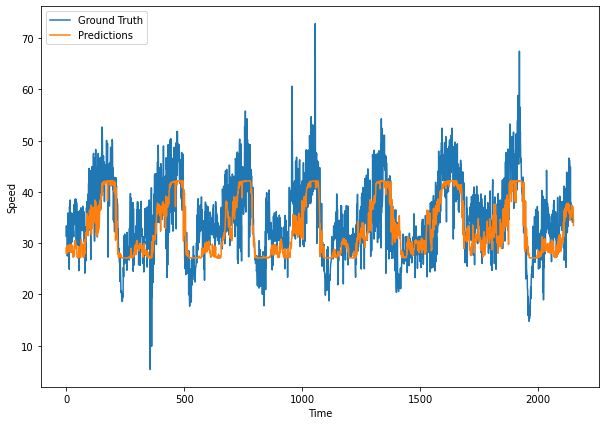

In [20]:
"""show one sensor time series"""
import matplotlib.pyplot as plt
y_sample = y_true[:, 2]
y_pred_sample = y_preds[:, 2]

plt.figure(figsize=(10,7))
plt.plot(range(len(y_sample)), y_sample, label='Ground Truth')
plt.plot(range(len(y_pred_sample)), y_pred_sample, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Speed')
plt.legend(loc="upper left")
plt.show()

In [22]:
"""Overall evaluation the predictions of the test data"""
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  0.000001 #add small values to true velocities to avoid division by zeros
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('RMSE: ', np.sqrt(mean_squared_error(y_true, y_preds)))
print('MAE: ', np.sqrt(mean_absolute_error(y_true, y_preds)))
print('MAPE: ', np.sqrt(mean_absolute_percentage_error(y_true, y_preds)), "%")

RMSE:  5.0132194
MAE:  1.9175608
MAPE:  3.892165350190563 %


# References

-  Shin, Y., & Yoon, Y. (2020). Incorporating dynamicity of transportation network with multi-weight traffic graph convolutional network for traffic forecasting. IEEE Transactions on Intelligent Transportation Systems.

- Yu, B., Yin, H., & Zhu, Z. (2017). Spatio-temporal graph convolutional networks: A deep learning framework for traffic forecasting. arXiv preprint arXiv:1709.04875.

- https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html

- https://github.com/Aguin/STGCN-PyTorch